In [1]:
import os
import cv2
import numpy as np
import trimesh
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid
from models.networks.smpl import SMPL
from models.networks.render import SMPLRenderer
from utils.util import load_obj, load_pickle_file, write_pickle_file, get_f2vts, get_f2vts_from_obj

In [2]:
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
class iPER_Dataset(Dataset):
    def __init__(self, imgs_path, pose_shape_pkl_path, image_size=256):
        imgs_fn_list = os.listdir(imgs_path)
        imgs_fn_list.sort()
        self.imgs_path_list = [os.path.join(imgs_path, img_fn) for img_fn in imgs_fn_list]
        self.pose_shape_pkl = load_pickle_file(pose_shape_pkl_path)
        self.Resize = transforms.Resize(image_size)
        self.ToTensor = transforms.ToTensor()
        
        if len(self.imgs_path_list) != self.pose_shape_pkl['pose'].shape[0]:
            print('images: ', len(self.imgs_path_list))
            print('smpls: ', self.pose_shape_pkl['pose'].shape[0])
        
        
    def __getitem__(self, index):
        img_path = self.imgs_path_list[index]
        img = self.Resize(Image.open(img_path).convert('RGB'))
        pose = self.pose_shape_pkl['pose'][index]
        shape = self.pose_shape_pkl['shape'][index]
        cam = self.pose_shape_pkl['cams'][index]
        
        output = {
            'image': self.ToTensor(img).float(),
            'pose': torch.from_numpy(pose).float(),
            'shape': torch.from_numpy(shape).float(),
            'cam': torch.from_numpy(cam).float()
        }
        return output
        
    def __len__(self):
        return len(self.imgs_path_list)

In [3]:
data_root = 'data/iPER'
batch_size = 4
tex_size = 3
image_size = 256
uv_size = 256
isHres = True

In [4]:
train_ID_list = []
for line in open(os.path.join(data_root, 'train.txt')):
    train_ID_list.append(line.split()[0])
print(len(train_ID_list))

164


In [5]:
video_ID = train_ID_list[0]
print(video_ID)

006/1/1


In [6]:
imgs_path = os.path.join(data_root, 'images', video_ID)
pose_shape_pkl_path = os.path.join(data_root, 'smpls', video_ID, 'pose_shape.pkl')
train_dataset = iPER_Dataset(imgs_path, pose_shape_pkl_path, image_size=image_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [7]:
for i, data in enumerate(train_loader):
    for key in data:
        print(key, data[key].size())
    if i >= 0:
        break

image torch.Size([4, 3, 256, 256])
pose torch.Size([4, 72])
shape torch.Size([4, 10])
cam torch.Size([4, 3])


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UVImageModel(nn.Module):
    def __init__(self, uv, image_size):
        super(UVImageModel, self).__init__()
        # (1, 3, image_size, image_size)
        self.weight = nn.Parameter(torch.zeros(1, 3, image_size, image_size) - 1.0)
         # (f, t, t, 2)
        self.f, self.t = uv.shape[:2]
        # (1, f, t*t, 2)
        uv = uv.reshape(1, self.f, self.t * self.t, 2)
        self.uv = uv
    
    def forward(self):
        uv_image = torch.tanh(self.weight)
        texture = F.grid_sample(uv_image, self.uv)
        # (1,3,f,t,t)
        texture = texture.view(1, 3, self.f, self.t, self.t)
        # (1,f,t,t,3)
        texture = texture.permute(0, 2, 3, 4, 1)

        return texture

    def get_uv_image(self):
        return torch.tanh(self.weight).detach()

In [9]:
smpl = SMPL(pkl_path='assets/smpl_model.pkl', isHres=isHres).cuda()
if isHres:
    faces = smpl.faces_hres
else:
    faces = smpl.faces
smpl_render = SMPLRenderer(faces=faces, tex_size=tex_size).cuda()

In [10]:
if isHres:
    vt, ft = load_pickle_file('assets/smpl_vt_ft_hres.pkl')
else:
    vt, ft = load_pickle_file('assets/smpl_vt_ft.pkl')
f2vts = torch.from_numpy(get_f2vts(vt, ft)).float().cuda()
print(f2vts.size())

torch.Size([55104, 3, 2])


In [11]:
# f2vts = torch.from_numpy(get_f2vts_from_obj('assets/uv_mapper.txt')).float().cuda()
# print(f2vts.size())

In [12]:
uv = smpl_render.points_to_sampler(f2vts[None])[0]
uv = uv.view(uv.shape[0], tex_size, tex_size, 2)
uv = uv * 2 - 1
print(uv.size())

torch.Size([55104, 3, 3, 2])


In [18]:
uv_image_model = UVImageModel(uv, image_size=uv_size).cuda()
opt = torch.optim.Adam(uv_image_model.parameters(), lr=1e-2)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=2, gamma=0.1)

def get_vis_tex(tex, fim):
    vis_face_ids = fim.unique()[1:].long()
    vis_tex = torch.zeros_like(tex) - 1
    vis_tex[vis_face_ids] = tex[vis_face_ids]
    return vis_tex

for epoch in range(5):
    print('Epoch: {} lr = {}'.format(epoch, opt.param_groups[0]['lr']))
    for cur_iter, data in enumerate(train_loader):
        img, shape, pose, cam = data['image'].cuda(), data['shape'].cuda(), data['pose'].cuda(), data['cam'].cuda()
        verts = smpl(shape, pose)
        verts = smpl_render.project_to_image(verts, cam, flip=True, withz=True)
        fim = smpl_render.render_fim(verts)
        tex = smpl_render.extract_tex_from_image(img, verts, repeat=False)
        bs = fim.size(0)
        vis_tex = []
        for i in range(bs):
            vis_tex.append(get_vis_tex(tex[i], fim[i]))
        vis_tex= torch.stack(vis_tex, dim=0)
        
        for _ in range(10):
            pred_tex = uv_image_model().repeat(bs, 1, 1, 1, 1)
            loss = criterion(pred_tex, tex)
            loss.backward()
            opt.step()
            opt.zero_grad()
        
        if cur_iter % 20 == 0:
            print('{}/{} loss = {}'.format(cur_iter, len(train_loader), loss.item()))
    scheduler.step()

Epoch: 0 lr = 0.01
0/145 loss = 1.4595983028411865
20/145 loss = 0.03711948171257973
40/145 loss = 0.034622903913259506
60/145 loss = 0.02711530029773712
80/145 loss = 0.0338527150452137
100/145 loss = 0.029920265078544617
120/145 loss = 0.026740578934550285
140/145 loss = 0.027288472279906273
Epoch: 1 lr = 0.01
0/145 loss = 0.027503112331032753
20/145 loss = 0.035968806594610214
40/145 loss = 0.036855507642030716
60/145 loss = 0.029094723984599113
80/145 loss = 0.030499495565891266
100/145 loss = 0.03688039630651474
120/145 loss = 0.0342886820435524
140/145 loss = 0.03544916585087776
Epoch: 2 lr = 0.001
0/145 loss = 0.026938093826174736
20/145 loss = 0.043516986072063446
40/145 loss = 0.023502016440033913
60/145 loss = 0.029188651591539383
80/145 loss = 0.03476066142320633
100/145 loss = 0.029537664726376534
120/145 loss = 0.02590172179043293
140/145 loss = 0.040163055062294006
Epoch: 3 lr = 0.001
0/145 loss = 0.029030494391918182
20/145 loss = 0.030572965741157532
40/145 loss = 0.051

In [20]:
uv_image = uv_image_model.get_uv_image()
print(uv_image.size())

torch.Size([1, 3, 256, 256])


In [21]:
print(uv_image.min(), uv_image.max())

tensor(-0.7616, device='cuda:0') tensor(0.8935, device='cuda:0')


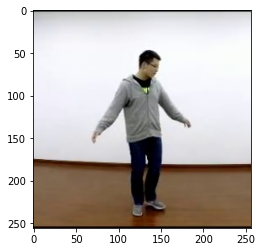

In [22]:
image_vis = (img.cpu().numpy()[0] * 255).astype(np.uint8).transpose(1, 2, 0)
plt.imshow(image_vis)

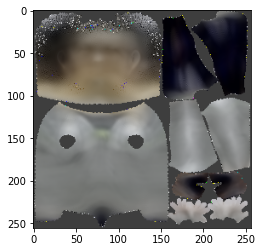

In [23]:
uv_image_vis = (uv_image.cpu().numpy()[0]* 255).astype(np.uint8).transpose(1, 2, 0)
plt.imshow(uv_image_vis)